# Patel SMQ2 LSK analysis
## Xiaonan Wang
## 17Feb2021

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns
import smqpp

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
print(smqpp.__version__)

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5
0.1.2


## Read in Data and Normalisation

In [2]:
adata = sc.read('./write/patel_smq2_LSK_raw.h5ad')

In [36]:
adata.obs['Condition1'].value_counts()

WT             710
p53KO          453
DKO            444
TKO            379
Fancd2KOhet    191
Aldh2KO        189
WThet          188
Name: Condition1, dtype: int64

In [3]:
sc.pp.filter_genes(adata, min_cells=1)

filtered out 6525 genes that are detected in less than 1 cells


In [7]:
smqpp.normalise_data(adata)

Calculate SF for genes:
Filtered matrix shape: (2554, 62)
Number of valid means:62
Calculate SF for erccs:
Filtered matrix shape: (2554, 8)
Number of valid means:8


/home/xw251/miniconda3/envs/scanpy170_new/lib/python3.6/site-packages/smqpp/__init__.py:369: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  adata.X = np.log1p(adata.X/adata.obs['sf_gene'][:,None])
/home/xw251/miniconda3/envs/scanpy170_new/lib/python3.6/site-packages/smqpp/__init__.py:372: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  adata.obsm['ERCC_norm'] = np.log1p(adata.obsm['ERCC']/adata.obs['sf_ercc'][:,None])


In [8]:
adata.raw = adata

In [9]:
adata.write('./write/patel_smq2_LSK_lognorm.h5ad')

## Select Highly Variable Genes

In [10]:
adata = sc.read('./write/patel_smq2_LSK_lognorm.h5ad')

In [11]:
smqpp.tech_var(adata, useERCC=True) 

MeanForFit:  9.697297244825371
27
Length of HVGs: 4359


/home/xw251/miniconda3/envs/scanpy170_new/lib/python3.6/site-packages/smqpp/__init__.py:502: RuntimeWarning: invalid value encountered in true_divide
  cv2s = (sStd/sMean)**2
/home/xw251/miniconda3/envs/scanpy170_new/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:296: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


/home/xw251/miniconda3/envs/scanpy170_new/lib/python3.6/site-packages/smqpp/__init__.py:601: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log',basey=10)
/home/xw251/miniconda3/envs/scanpy170_new/lib/python3.6/site-packages/smqpp/__init__.py:602: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log',basex=10)


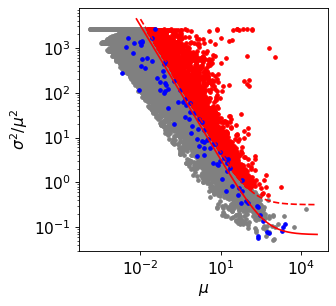

In [12]:
smqpp.plot_tech_var(adata)

In [13]:
adata.shape

(2554, 24528)

In [14]:
adata = adata[:,adata.uns['varGenes']['genes']['highVar']].copy()

In [15]:
adata.shape

(2554, 4359)

In [16]:
adata.write('./write/patel_smq2_LSK_lognorm_HVG.h5ad')

## Visualisation

In [14]:
adata = sc.read('./write/patel_smq2_LSK_lognorm_HVG.h5ad')

computing PCA
    with n_comps=50
    finished (0:00:00)


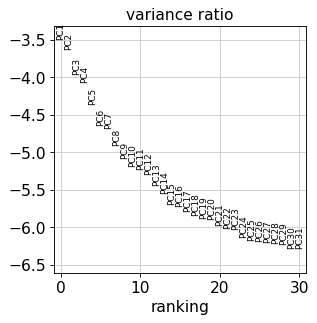

In [15]:
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [16]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


In [17]:
keys2plot = ['batch', 'n_counts', 'n_genes', 'phase', 'Sex', 'Condition', 'Condition1', 'MouseID']

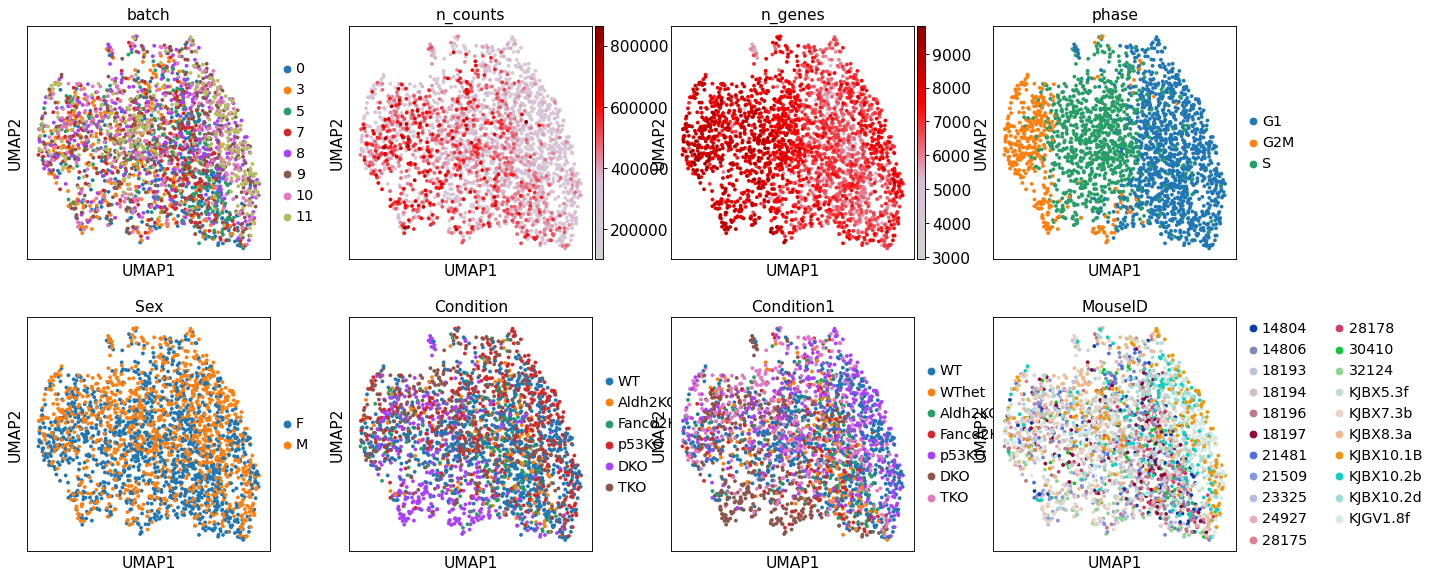

In [18]:
sc.pl.umap(adata, color=keys2plot, color_map=cmap)

In [19]:
adata.write('./write/patel_smq2_LSK_processed.h5ad')

## Regress Out Cell Cycle and n_genes

In [20]:
adata = sc.read('./write/patel_smq2_LSK_processed.h5ad')

In [21]:
# regress out cell cycle effect and n_genes
sc.pp.regress_out(adata, ['S_score', 'G2M_score', 'n_genes', 'n_counts', 'percent_mito'])
sc.pp.scale(adata)

regressing out ['S_score', 'G2M_score', 'n_genes', 'n_counts', 'percent_mito']
    finished (0:00:16)


In [22]:
# Repeat the pipeline again
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


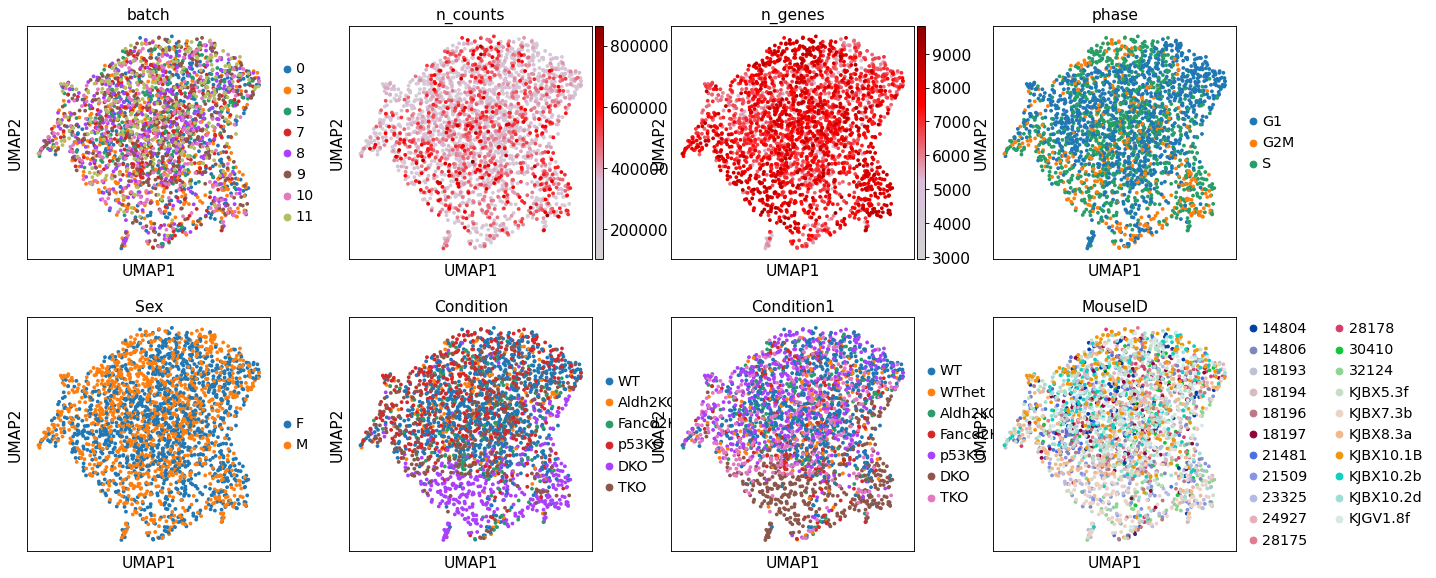

In [23]:
sc.pl.umap(adata, color=keys2plot, color_map=cmap)

In [24]:
# save another oject as regressed out
adata.write('./write/patel_smq2_LSK_processed_regressout_cellcycle.h5ad')

In [2]:
adata = sc.read('./write/patel_smq2_LSK_processed_regressout_cellcycle.h5ad')

In [3]:
# Define colors
c = {'WT': '#657F81',
    'Aldh2KO': '#1CD9FF',
    'Fancd2KO': '#51E603',
    'DKO':'#FA1C26',
    'TKO': '#605BE8',
    'p53KO':'#ED9514'}
adata.uns['Condition_colors'] = [c[x] for x in adata.obs['Condition'].cat.categories]

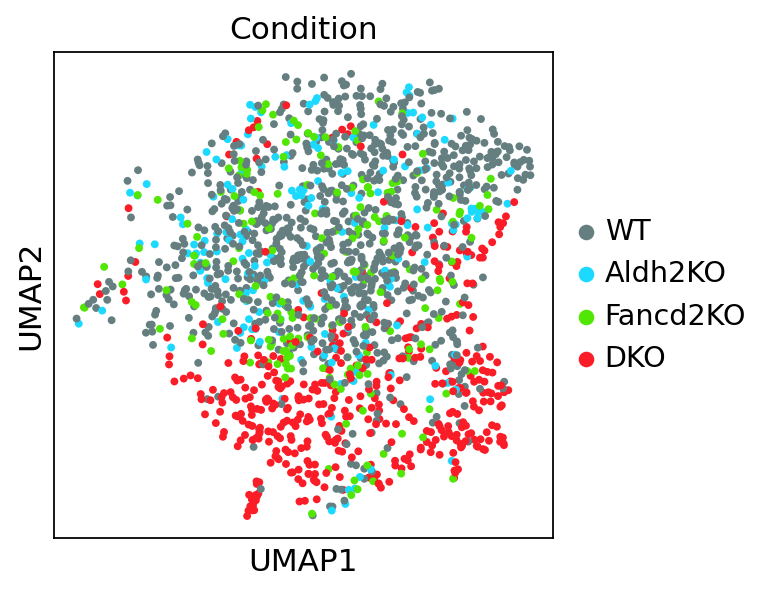

In [14]:
cat = ['WT', 'Aldh2KO', 'Fancd2KO', 'DKO']
sc.pl.umap(adata[np.in1d(adata.obs.Condition, cat)], s=50, color='Condition', legend_loc='right margin')

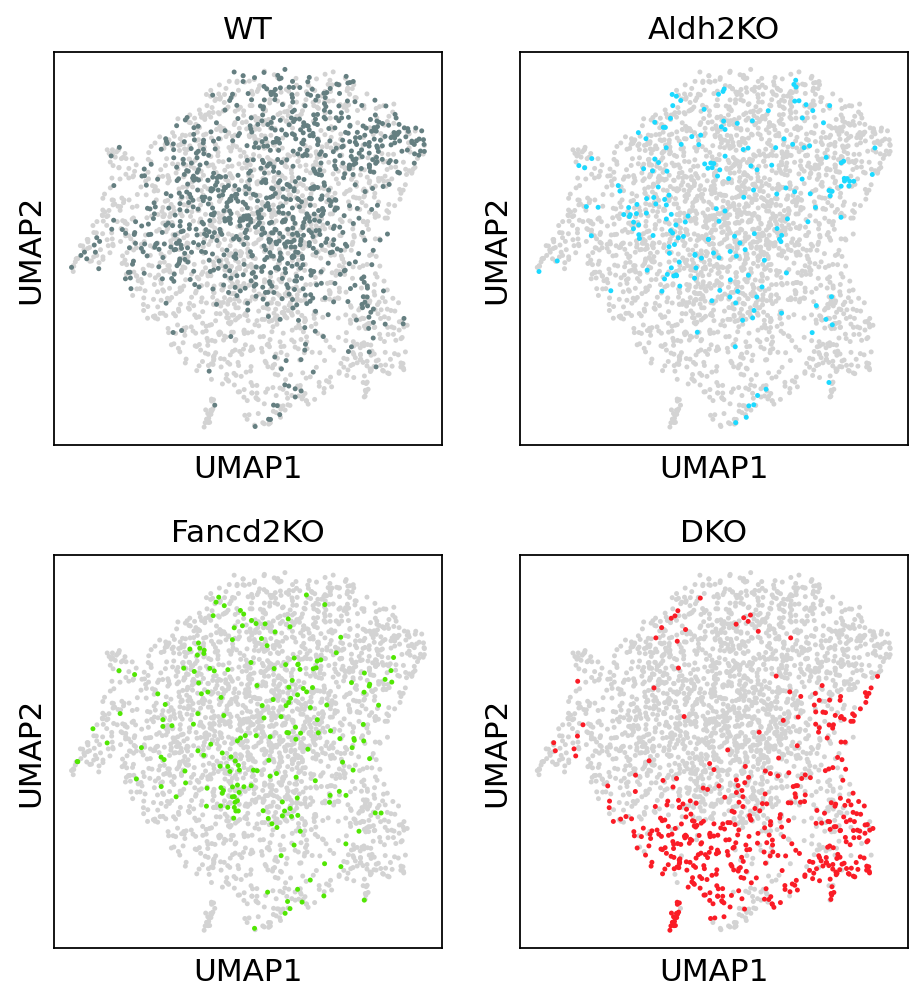

In [10]:
# split in condition
fig, ax=plt.subplots(2,2, figsize=(6,6.5))
ax = ax.flatten()
for i in range(len(cat)):
    sc.pl.umap(adata,s=20, color='Condition', groups=cat[i], title=cat[i], ax=ax[i], show=False, legend_loc='')
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig('Fig1b.pdf', bbox_inches='tight')

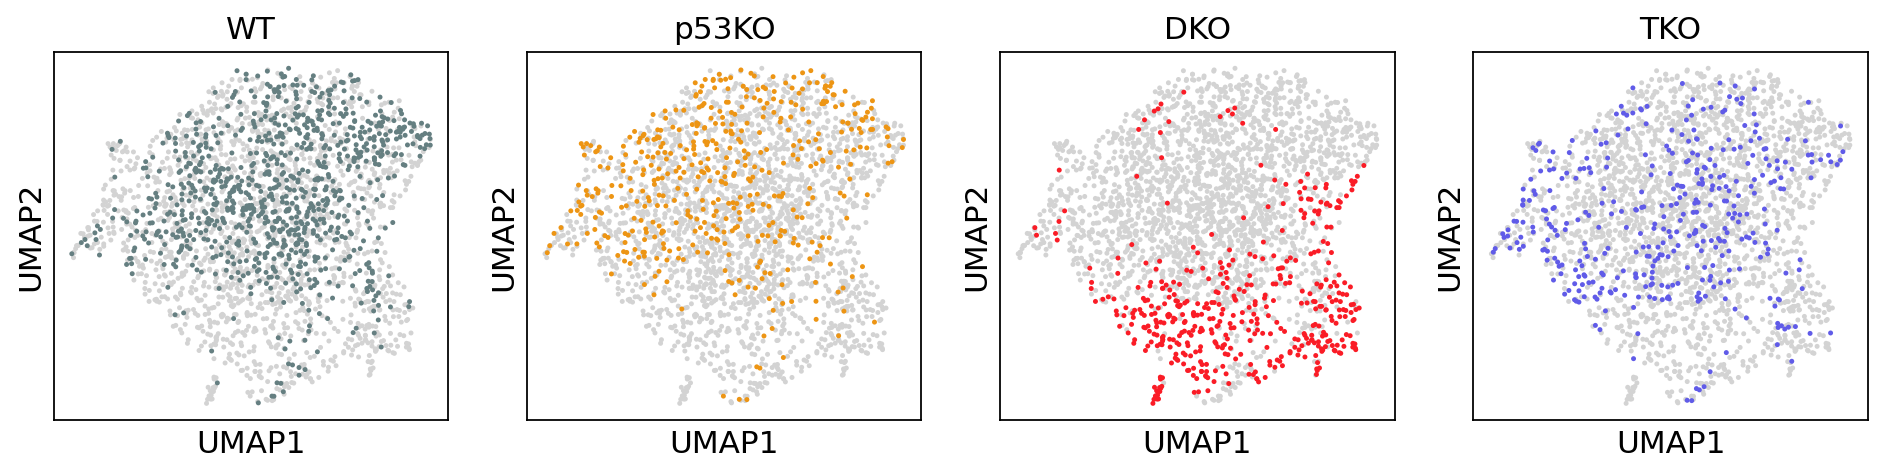

In [19]:
# split in condition
cat = ['WT', 'p53KO', 'DKO', 'TKO']
fig, ax=plt.subplots(1,4, figsize=(12,3.2))
ax = ax.flatten()
for i in range(len(cat)):
    sc.pl.umap(adata,s=20, color='Condition', groups=cat[i], title=cat[i], ax=ax[i], show=False, legend_loc='')
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig('Fig3a.pdf', bbox_inches='tight')

In [62]:
adata.write('./write/patel_smq2_LSK_processed_regressout_cellcycle.h5ad')

## Cell Type Analysis

In [2]:
adata = sc.read('./write/patel_smq2_LSK_processed_regressout_cellcycle.h5ad')

In [68]:
DahlinL = pd.read_csv('Proj_results_dahlin.csv', index_col=0)
NestorowaL = pd.read_csv('Proj_results_nestorowa.csv', index_col=0)

In [69]:
print(DahlinL.columns)
print(NestorowaL.columns)

Index(['MinDist', 'MedianDist', 'MaxDist', 'SD', 'Dahlin_CT'], dtype='object')
Index(['MinDist', 'MedianDist', 'MaxDist', 'SD', 'Nestorowa_CT'], dtype='object')


In [70]:
adata.obs['Dahlin_CT'] = DahlinL['Dahlin_CT']
adata.obs['Nestorowa_CT'] = NestorowaL['Nestorowa_CT']

In [110]:
# Replace the HSC and Immature populations in Dahlin Landscape with Nestorowa annotation
anno = np.array(adata.obs['Dahlin_CT'].values).copy()
idx = np.logical_or(adata.obs['Dahlin_CT'] == 'HSC', adata.obs['Dahlin_CT'] == 'Immature')
anno[idx] = adata.obs['Nestorowa_CT'][idx]
toEx = ['MPP1', 'MPP2', 'MPP3']
anno[[x in toEx for x in anno]] = 'MPP'
toEx = ['Early erythoid', 'Middle erythoid', 'Late erythoid']
anno[[x in toEx for x in anno]] = 'Erythoid'
adata.obs['Combined_CT'] = anno
adata.obs['Combined_CT'] = adata.obs['Combined_CT'].astype('category')

In [111]:
adata.obs['Combined_CT'].value_counts()

LMPP             638
MPP              517
MEP              363
LTHSC            330
GMP              232
Lymphoid         197
STHSC             83
Neutrophil        63
Erythoid          63
Megakaryocyte     45
Basophil          23
Name: Combined_CT, dtype: int64

In [112]:
adata.obs['Combined_CT']= adata.obs['Combined_CT'].cat.reorder_categories([
    'LTHSC', 'STHSC', 'MPP', 'LMPP',
       'GMP', 'MEP', 'Megakaryocyte', 'Erythoid', 'Basophil', 'Lymphoid', 'Neutrophil'])

LTHSC
STHSC
MPP
LMPP
GMP
MEP
Megakaryocyte
Erythoid
Basophil
Lymphoid
Neutrophil


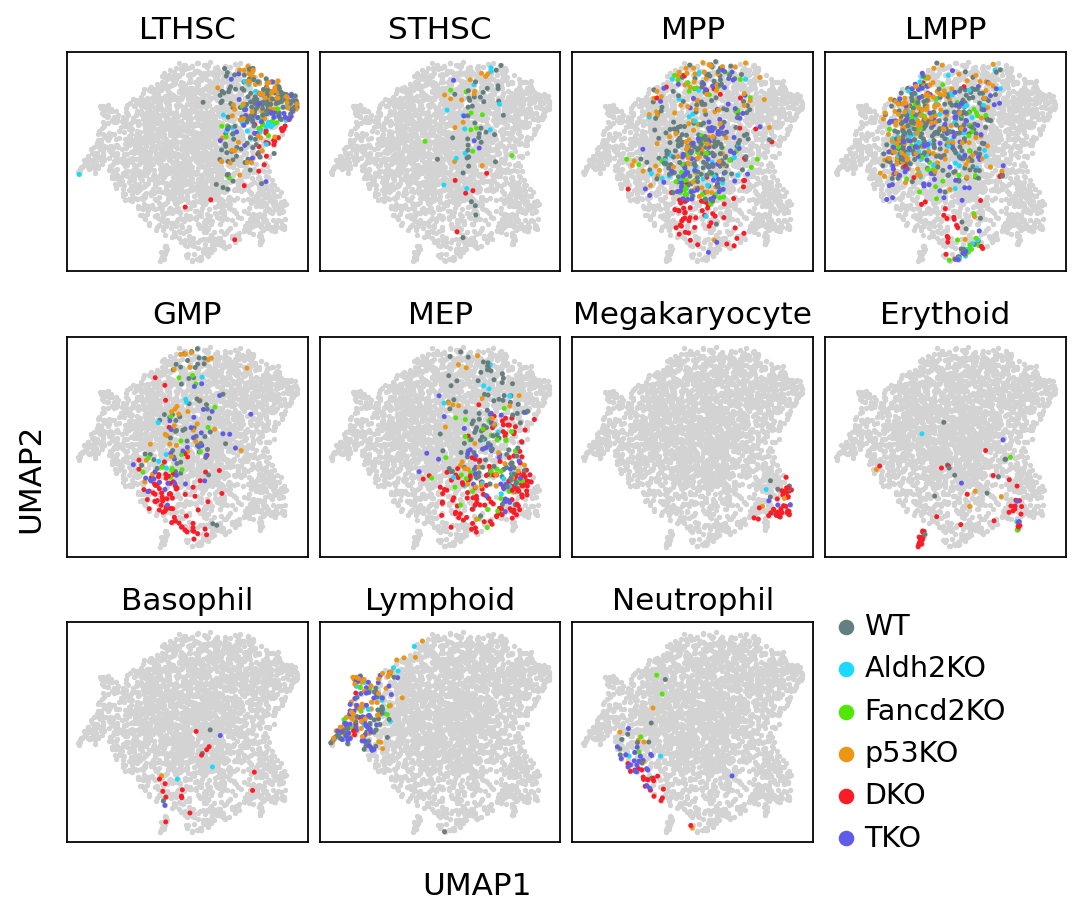

In [20]:
# split in condition
fig, ax=plt.subplots(3,4, figsize=(8,6.5), squeeze=False)
cat = adata.obs['Combined_CT'].cat.categories
for i in range(len(cat)):
    colidx = i%4
    rowidx = np.floor(i/4).astype(int)
    print(cat[i])
    ax[rowidx][colidx].scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1],s=2, c='#d3d3d3')
    if i != 10:
        legend_loc = ''
    else:
        legend_loc = 'right margin'
    sc.pl.umap(adata[adata.obs['Combined_CT'] == cat[i]],s=20, color='Condition', title=cat[i], ax=ax[rowidx][colidx], show=False, legend_loc=legend_loc)
    ax[rowidx][colidx].set_xlabel('')
    ax[rowidx][colidx].set_ylabel('')

for i in [11]:
    fig.delaxes(ax.flatten()[i])
    
fig.text(0.5, 0.1, 'UMAP1', ha='center')
fig.text(0.14, 0.5, 'UMAP2', va='center', rotation='vertical')

plt.subplots_adjust(wspace=0.05, hspace=0.3)
plt.savefig('Fig2g.pdf',bbox_inches ='tight')

In [ ]:
adata.write('./write/patel_smq2_LSK_processed_regressout_cellcycle.h5ad')

## Look into Clusters and Cell Types

In [2]:
adata = sc.read('./write/patel_smq2_LSK_processed_regressout_cellcycle.h5ad')

Plot cell phase proportions

In [40]:
adata.obs.phase = adata.obs.phase.cat.reorder_categories(['G1', 'S', 'G2M'])

In [43]:
tab = pd.crosstab(adata.obs.Condition, adata.obs.phase, normalize=0)*100

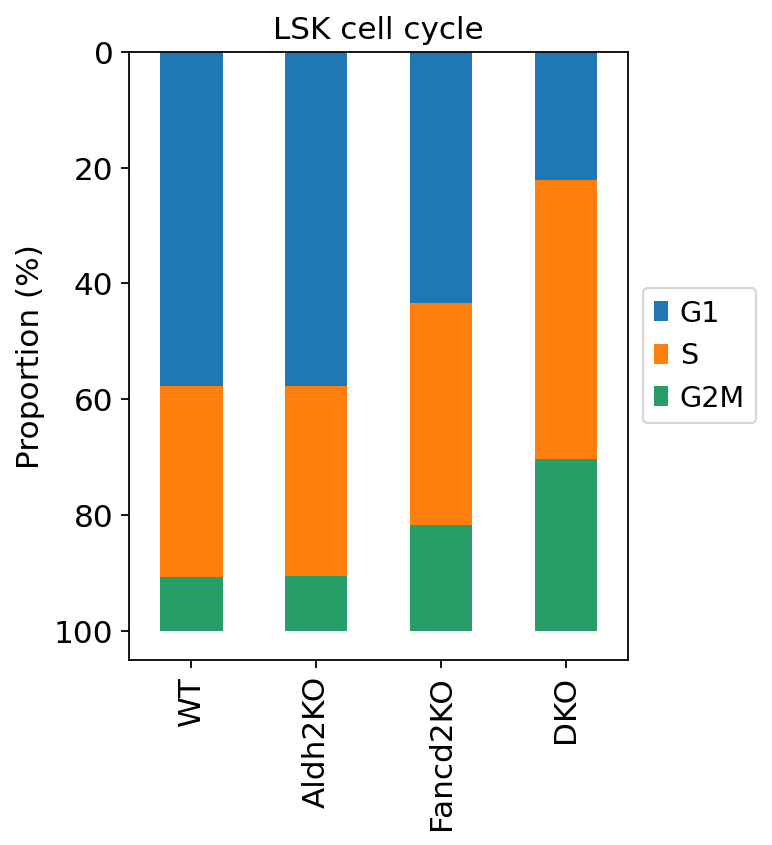

In [45]:
fig, ax = plt.subplots(figsize=(4,5))
tab.iloc[[0,1,2,4],:].plot.bar(stacked=True, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(False)
ax.set_ylabel('Proportion (%)')
ax.set_xlabel('')
ax.set_title('LSK cell cycle')
plt.gca().invert_yaxis()
plt.savefig('Fig_1c.pdf', bbox_inches='tight')

Plot cell type proportions

In [22]:
tab1 = pd.crosstab(adata.obs['Combined_CT'], adata.obs['Condition'], normalize=1).T*100

In [23]:
tab1.head(2)

Combined_CT      LTHSC     STHSC        MPP       LMPP       GMP        MEP  \
Condition                                                                     
WT           18.040089  4.454343  21.603563  27.839644  6.458797  13.140312   
Aldh2KO      14.285714  6.349206  17.989418  38.624339  4.232804   7.407407   

Combined_CT  Megakaryocyte  Erythoid  Basophil  Lymphoid  Neutrophil  
Condition                                                             
WT                0.668151  1.113586  0.334076  5.122494    1.224944  
Aldh2KO           0.529101  1.058201  1.058201  7.407407    1.058201

In [28]:
c = {'WT': '#657F81',
    'Aldh2KO': '#1CD9FF',
    'Fancd2KO': '#51E603',
    'DKO':'#FA1C26',
    'TKO': '#605BE8',
    'p53KO':'#ED9514'}

In [22]:
adata.uns['Condition_colors'] = [c[x] for x in adata.obs['Condition'].cat.categories]

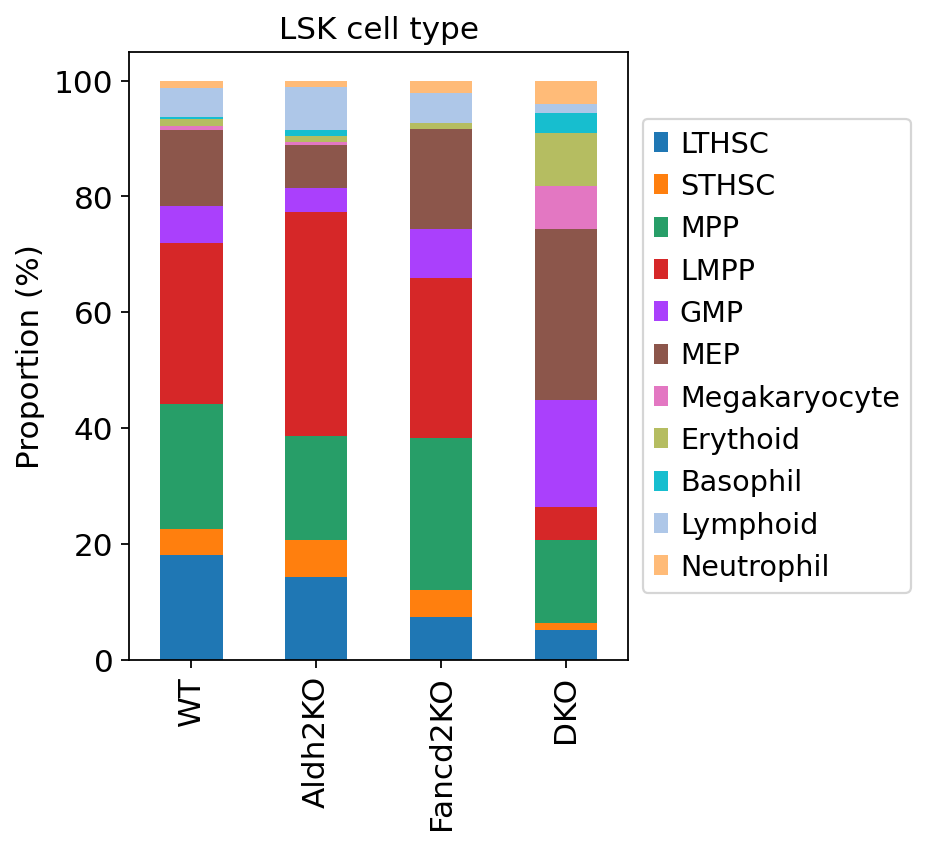

In [50]:
fig, ax = plt.subplots(figsize=(4,5))
tab1.iloc[[0,1,2,4],:].plot.bar(stacked=True, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(False)
ax.set_ylabel('Proportion (%)')
ax.set_xlabel('')
ax.set_title('LSK cell type')
plt.savefig('Fig_2h.pdf', bbox_inches='tight')

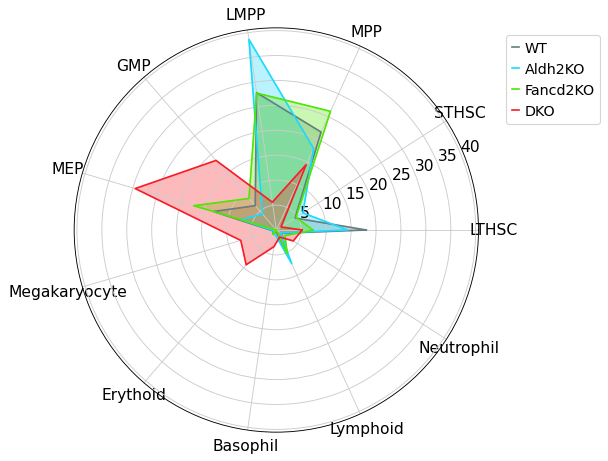

In [103]:
plt.figure(figsize=(10, 6))
plt.subplot(polar=True)
nct = len(tab1.columns)
theta = np.linspace(0, 2 * np.pi, nct+1)
lines, labels = plt.thetagrids(np.linspace(start=0, stop=360, num=11, endpoint=False), (tab1.columns))

idx = [0,1,2,4]
for i in idx:
    v = tab1.iloc[i,:].values
    plt.plot(theta, np.append(v, v[0]), c=c[tab1.index[i]])
    plt.fill(theta, np.append(v, v[0]), c=c[tab1.index[i]], alpha=0.3)
    
plt.legend(labels=tab1.index[idx], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Fig2i.pdf',bbox_inches = 'tight')

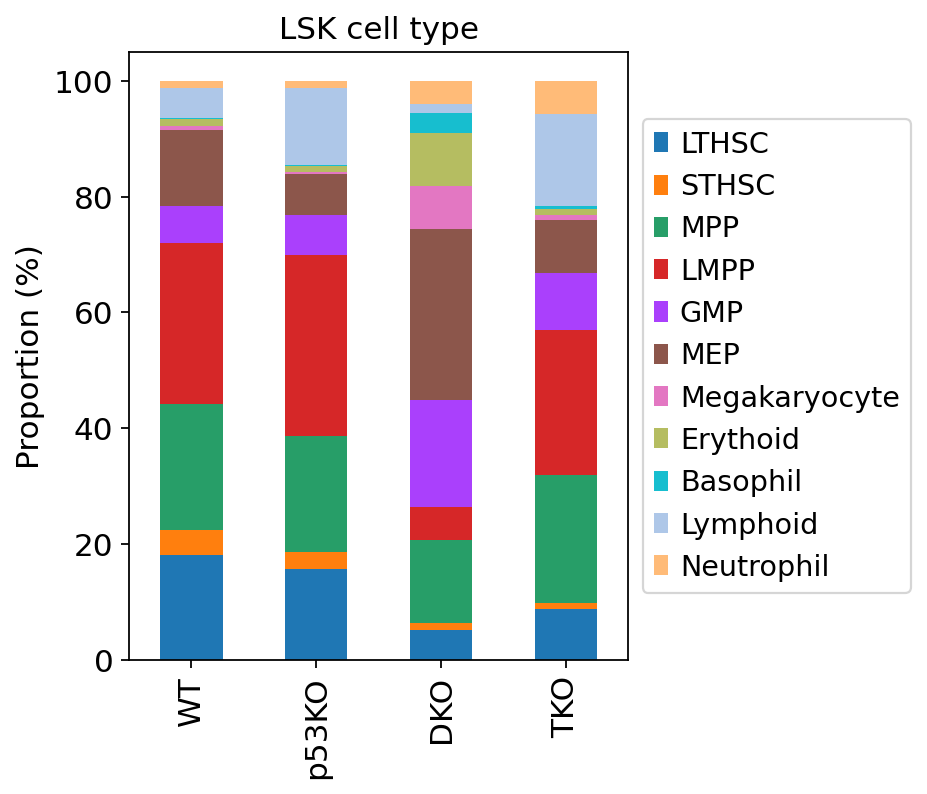

In [49]:
fig, ax = plt.subplots(figsize=(4,5))
tab1.iloc[[0,3,4,5],:].plot.bar(stacked=True, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(False)
ax.set_ylabel('Proportion (%)')
ax.set_xlabel('')
ax.set_title('LSK cell type')
plt.savefig('Supp_Fig3b.pdf', bbox_inches='tight')

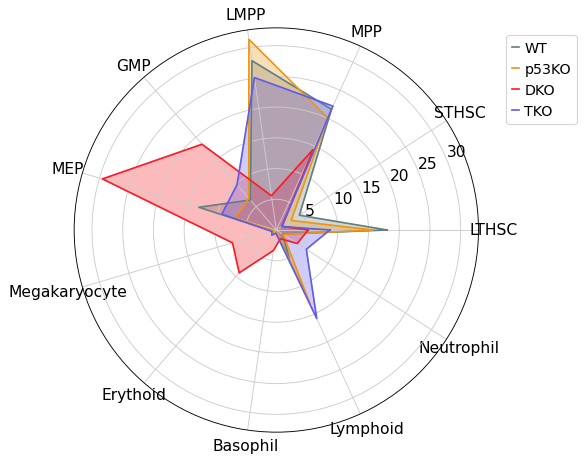

In [104]:
plt.figure(figsize=(10, 6))
plt.subplot(polar=True)
nct = len(tab1.columns)
theta = np.linspace(0, 2 * np.pi, nct+1)
lines, labels = plt.thetagrids(np.linspace(start=0, stop=360, num=11, endpoint=False), (tab1.columns))

idx = [0,3,4,5]
for i in idx:
    v = tab1.iloc[i,:].values
    plt.plot(theta, np.append(v, v[0]), c=c[tab1.index[i]])
    plt.fill(theta, np.append(v, v[0]), c=c[tab1.index[i]], alpha=0.3)
    
plt.legend(labels=tab1.index[idx], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('./figures/polar_ct2.pdf',bbox_inches = 'tight')

In [ ]:
adata.write('./write/patel_smq2_LSK_processed_regressout_cellcycle.h5ad')